In [ ]:
"""
 Copyright (c) 2021-2024 D-Robotics Corporation

 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at

      http://www.apache.org/licenses/LICENSE-2.0

 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
"""

In [1]:
!cat /proc/meminfo | grep Mem

MemTotal:        3304416 kB
MemFree:          113848 kB
MemAvailable:    1396688 kB


In [2]:
# 导入所需要的包
import numpy as np
import bpu_infer_lib

In [3]:
# 构建推理对象
infer_obj = bpu_infer_lib.Infer(False)

In [4]:
# 加载模型
infer_obj.load_model("model/ConvNeXt_femto_224x224_nv12.bin")

The model path is valid and points to a regular file.
[BPU_PLAT]BPU Platform Version(1.3.6)!
[HBRT] set log level as 0. version = 3.15.49.0
[DNN] Runtime version = 1.23.8_(3.15.49 HBRT)
[A][DNN][packed_model.cpp:247][Model](2024-09-04,11:26:14.244.981) [HorizonRT] The model builder version = 1.23.8
[W][DNN]bpu_model_info.cpp:491][Version](2024-09-04,11:26:14.287.599) Model: ConvNeXt-deploy_224x224_nv12. Inconsistency between the hbrt library version 3.15.49.0 and the model build version 3.15.54.0 detected, in order to ensure correct model results, it is recommended to use compilation tools and the BPU SDK from the same OpenExplorer package.


True

In [5]:
# 加载图片及前向推理
ret = infer_obj.read_img_to_nv12("data/cheetah.JPEG", 0)
infer_obj.forward()

In [6]:
ptr1 = infer_obj.get_infer_res(0, 1000) # 输入类别数
print(len(ptr1))
array1 = [ptr1[i] for i in range(1000)]
out_arr = np.array(array1).astype(np.float32) # 未归一化的置信度
print(out_arr.shape)
print(out_arr[:10])

1000
(1000,)
[-0.05896774  0.45391735  0.21716273  0.53483135  0.38556907 -0.0536794
  0.10851479  0.00952432  0.4617404   1.3769226 ]


In [7]:
def np_softmax(arr):
    exp_out = np.exp(arr)
    sum_exp_out = np.sum(exp_out, axis=-1, keepdims=True)
    probs = exp_out / sum_exp_out
    return probs

def sample_logits(logits, fixed_output_token, temperature=1.0, top_p=0.8):
    probs = np_softmax(logits)
    max_index = np.argmax(probs)
    return max_index, probs

max_ind, probs = sample_logits(out_arr, True) # softmax回归
max_ind

293

In [8]:
import json

# 读取JSON文件并将其内容导入到Python列表
with open('data/ImageNet_1k.json', 'r', encoding='utf-8') as json_file:
    labels = json.load(json_file)

print("max_ind:", max_ind)
print(labels[max_ind], probs[max_ind])

max_ind: 293
cheetah, chetah, Acinonyx jubatus 0.86143464


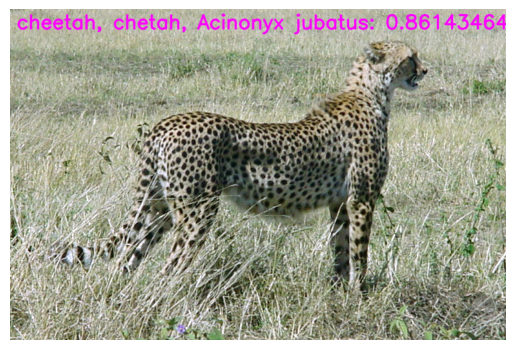

In [9]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('data/cheetah.JPEG')

# Define the text to write
text = labels[max_ind] + ": " + str(probs[max_ind])

# Define the bottom-left corner of the text string in the image
org = (10, 30)  # X and Y coordinates

# Define the font, scale, color, and thickness of the text
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
color = (255, 0, 255)  # red color in BGR
thickness = 2

# Write the text on the image
cv2.putText(image, text, org, font, font_scale, color, thickness, cv2.LINE_AA)

# Convert the image from BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using Matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Hide the axis
plt.show()

In [11]:
!hrt_model_exec perf --model_file model/ConvNeXt_femto_224x224_nv12.bin \
                    --model_name="" \
                    --core_id=0 \
                    --frame_count=200 \
                    --perf_time=0 \
                    --thread_num=4 \
                    --profile_path="."

hrt_model_exec perf --model_file model/ConvNeXt_femto_224x224_nv12.bin --model_name= --core_id=0 --frame_count=200 --perf_time=0 --thread_num=4 --profile_path=.
I0000 00:00:00.000000 1201832 vlog_is_on.cc:197] RAW: Set VLOG level for "*" to 3
I0904 11:26:53.691887 1201832 main.cpp:233] profile_path: . exsit!
[BPU_PLAT]BPU Platform Version(1.3.6)!
[HBRT] set log level as 0. version = 3.15.47.0
[DNN] Runtime version = 1.23.5_(3.15.47 HBRT)
[A][DNN][packed_model.cpp:247][Model](2024-09-04,11:26:53.817.823) [HorizonRT] The model builder version = 1.23.8
[W][DNN]bpu_model_info.cpp:491][Version](2024-09-04,11:26:53.860.392) Model: ConvNeXt-deploy_224x224_nv12. Inconsistency between the hbrt library version 3.15.47.0 and the model build version 3.15.54.0 detected, in order to ensure correct model results, it is recommended to use compilation tools and the BPU SDK from the same OpenExplorer package.
Load model to DDR cost 170.269ms.
I0904 11:26:53.862515 1201832 function_util.cpp:323] get mode